# Urban Traffic Anomaly Detection using Variational Autoencoders (VAE)
## Using VAE to build a Traffic Anomaly Detector for Early Accident Warnings

In this project, we aim to detect anomalies in urban traffic patterns using a probabilistic machine learning approach based on Variational Autoencoders (VAE). 

We will train the VAE on typical traffic data so that it learns common patterns. Then, we will detect anomalies as deviations from these learned patterns.

The dataset used is the METR-LA dataset, which contains traffic speed readings from sensors in Los Angeles collected every 5 minutes.


---
## **Outline**
### **Goal**

>Build a system that spots unusual traffic patterns in real time and warns authorities of possible upcoming accidents.


### **How It Works, Simply: “Normal” vs “Strange”**:

   * We first teach a model what everyday traffic looks like (no crashes OR really unbalanced dataset with low incidents/traffic-recordings ratio <span style="color:red">{*we suppose our dataset to be really unbalanced, as they do in a paper*}</span> ).
   * Then, in operation, the model watches incoming traffic data and flags anything that “doesn’t fit” its learned normal patterns.

1. **Data in Chunks**

   * preprocessing 
      * missing data imputation, if any.
      * standardization only on training data, or on test data too  (???????????????????????????
      * NORMAL TRAFFIC DATA SHOW TIME PATTERNS EVERYTIME EVEN IN REGULAR CONDITIONS, HOW TO ADDRESS THIS THING \
      <span style="color:red">{*should a column with categorical number of week day be added to keep track of regular patterns in time? What about long period patterns, as monthly and yearly patterns??????????????????????????????*}</span> 
   * We group sensor readings into short time blocks (e.g. one hour of readings) \
   <span style="color:red">{*could the split be made by letting in and letting out a single timestamped row at a time?....for sure it is COMPUTATIONALLY DEMANDINg, any advantage THEN?....???????????????' no sense, we only need batches*}</span> 

2. **Model Magic (Under the Hood)**

   * A compact “autoencoder” network learns to compress each block into a small summary.... 
      * build the model (which latent sizes, layer widths, KL-weight schedules, etc....)
      * maximize ELBO to optimize the parameters (see below theory)
      * test (cross validation/others on a validation set (e.g. last 10% of days) )
   * <span style="color:red">*TRY DIFFERENT VAE VERSIONS....LOOKING AT LITERATURE RIGHT NOW*</span> 


3. **Flagging Early Warnings**
   * ....and then reconstruct it back. If it reconstructs poorly, that block is probably unusual.
   * We check reconstruction error: big errors → possible problem.
   * When multiple sensors or blocks light up before a known crash, we call those “early warnings.”


## **About 'Flagging Early Warnings' (TEMPORARY DRAFT)**

Once our model has learned what “normal” traffic looks like, here’s how we catch potential accidents before they happen:

1. **Watch the Reconstruction Error**

   * **What it is**: For each time block and each sensor, the model tries to rebuild (reconstruct) the recorded speeds. If the rebuilt value is very different from the real one, that’s an error.
   * **Why it matters**: A low error means “all good,” a high error means “something strange is going on here.”
   * **Compute a Simple Anomaly Score**

    * For each sensor in a block, calculate specific sensor’s reconstruction error across the multiple rows of the block. Could be the MSE??????

      $$
        \mathrm{Error}_s \;=\;\sum_{t\in\text{block}}(\text{actual}_{t,s}-\hat{\text{predicted}}_{t,s})^2
      $$


2. **Ways to Flag Glitches** 
    * **2.1 Per-Sensor Alerts (Instant)**

      * **What:** As soon as any sensor’s error > its own cutoff (e.g. 99ᵗʰ-percentile), you send a “glitch” alert for that sensor.
      * **Why:** Super fast, catches tiny/local faults immediately.
      * **Trade-off:** Every alert looks equally urgent and you might get noise.

    * **2.2 Add a Quick Severity Score (Prioritized)**

      * **Measure:**

        1. **MaxErrorRatio** = worst sensor’s error ÷ its normal 95ᵗʰ-percentile error
        2. **CountFired** = how many sensors are over their cutoffs
        3. **SeverityScore** = MaxErrorRatio × √CountFired

      * **Map to Low/Med/High:**

        * Low if < 2 • Medium if 2–5 • High if ≥ 5
      * **Why:** Highlights big or widespread glitches, cuts noise, still trivial math.
    
    * **2.3 Set Smart Thresholds**
      * Summarize across sensors, e.g.:

          $$
            \text{BlockScore} = \max_s \; \text{Error}_{s}
          $$
      * Intuition: if even one sensor suddenly behaves oddly, the block gets flagged.
      * Look at BlockScores over a week of known “normal” days.
      * Choose a cutoff (e.g. the 95ᵗʰ percentile) so that only the largest 5% of errors trigger an alert.
      * This keeps false alarms low while still catching real issues.
      


 


4. **Detecting Early Warnings vs. Aftermath**

   * **Early Warning**: If a high BlockScore occurs **before** any reported incident, mark it as a “precursor.”
   * **Aftermath**: If it happens **during or immediately after** a crash, label it “consequence.”
   * We’ll visualize these on a timeline—warning flags should lead incidents by several minutes if truly predictive.

5. **Optional Classifier for Precision**

   * Feed the model’s internal summary (its compact “code” for each block) into a tiny decision tree or logistic regression.
   * Train it on a handful of labeled examples (blocks known to be “warnings” vs. “consequences”). \
   <span style="color:red">{*just know two datasets needs to be jointed and a categorical variable eventually added. (???). We also have a dataset with coordinates of incidents, and our traffic dataset has references to coordinates too*}</span>
   * This helps the system learn subtle patterns that pure error thresholds might miss (e.g. gradual slowdowns vs. sudden stops).

6. **(Ideal) Real-Time Alerting Flow**

   1. New block arrives every 5 min.
   2. Model computes BlockScore on the fly.
   3. If BlockScore > threshold → flag an alert.
   4. Check classifier (if used) to tag it “precursor” or “aftermath.”
   5. Push notification to dashboard and/or SMS/email to operators.


This step-by-step approach keeps things transparent—each alert is simply “error too big,” optionally refined by a lightweight classifier, and timed relative to known incidents to tell if it really is an early warning.




## **Do We Have Enough Data?**

* **Learning “normal” traffic**: \~2–4 weeks of continuous data at 5 min intervals (i.e. 400–800 windows) usually suffices to cover daily and weekly patterns.
* **Distinguishing precursors vs. consequences**: Aim for **50–100 past incidents** to reliably calibrate thresholds and/or train the simple classifier.

  * If you see \~1 incident per day, 2–3 months of data will do; if incidents occur \~1 per week, plan for 1–2 years of history.

In short: modeling normal behavior is quick, but confidently tagging early warnings requires a few dozen labeled incidents.


## **3-Week Roadmap (TEMPORARY DRAFT)**

| Week  | Focus & Deliverables                                                                                                                                                                                                                                                                                                                |
| ----- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1** | **VAE model** <br>• Preprocessing on our traffic data.<br>• Add day-of-week and hour-of-day so the model knows “rush hour vs. quiet time.” <span style="color:red">{*?????not sure ?????*}</span> <br>• Build a simple model that learns “normal” patterns. <br>• Test it. <br>• Calibrate the “error threshold” so we catch real incidents but avoid too many false alarms.  <span style="color:red">{*How to compute each sensor’s 95ᵗʰ-percentile error?*}</span>                           |                                                                           |
| **2** | **Early-Warning Classifier & Demo**<br>• Either build per-sensor alerts AND/OR add SeverityScore formula & pick cutoffs. <br> • or Mark blocks before known accidents as “warnings” and others as “after” or “normal.”<br>• Train a small classifier on the model’s summary outputs to tell “warning vs. aftermath.”<br>• Put together a simple live dashboard that shows sensor map, current alerts, and warning lead times. |
| **4** | **(Optional) real time pipeline**<br>• Hook into real-time pipeline (every 5 min)<br>• Dashboard shows sensor flags + severity |

### **Ideal goal** (again)

> Real time system to flag anomalies and pop out early-warnings

## **Variational Autoencoder (VAE)**

A Variational Autoencoder (VAE) is a type of generative model that learns to encode input data into a compressed latent space and then reconstruct it as accurately as possible. Unlike traditional autoencoders, VAEs add a probabilistic framework that makes the latent space continuous and meaningful, which is useful for tasks like anomaly detection.

### Main Components

#### 1. **Encoder**
The encoder network takes an input (e.g., a time window of traffic data) and maps it to a latent distribution. Instead of directly outputting a single latent vector, the encoder outputs:

- A mean vector $\mu$
- A standard deviation (or log variance) vector $\log(\sigma^2)$

These define a multivariate normal distribution from which we sample the latent variable $z$.

#### 2. **Latent Sampling**
To allow backpropagation through the sampling process, VAEs use the **reparameterization trick**:

$$
z = \mu + \sigma \cdot \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, I)
$$

This makes the sampling step differentiable.

#### 3. **Decoder**
The decoder takes the sampled latent variable $z$ and tries to reconstruct the original input data. The goal is to learn a meaningful latent space that can generate realistic reconstructions.

### Loss Function

The VAE optimizes two components in the loss:

1. **Reconstruction Loss** (e.g., Mean Squared Error):

$$
\mathcal{L}_{\text{recon}} = ||x - \hat{x}||^2
$$

This penalizes the model when its reconstruction $\hat{x}$ is far from the original input $x$.

> **Why use MSE as reconstruction loss?**
>
> Theoretically, we want to maximize the log-likelihood of the reconstruction, i.e., $\log p(x|z)$. If we assume that the decoder’s output is Gaussian with fixed variance (i.e., $p(x|z) = \mathcal{N}(\hat{x}, \sigma^2 I)$), then:
>
> $$
> \log p(x|z) = -\frac{1}{2\sigma^2} ||x - \hat{x}||^2 + \text{const}
> $$
>
> So minimizing the squared error (MSE) is equivalent to maximizing the likelihood. That’s why MSE acts as a **proxy** for the negative log-likelihood in practice.


2. **Kullback-Leibler (KL) Divergence**:

$$
\mathcal{L}_{\text{KL}} = D_{\text{KL}}(q(z|x) || p(z))
$$

This measures how much the learned latent distribution $q(z|x)$ (given by the encoder) deviates from the standard normal prior $p(z) = \mathcal{N}(0, I)$.

> **In practice**, the encoder outputs $\mu$ and $\log(\sigma^2)$, and the KL divergence between the approximate posterior and the prior can be computed in closed form:
>
> $$
> \mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum \left(1 + \log(\sigma^2) - \mu^2 - \sigma^2\right)
> $$
>
> This encourages the model to keep the latent representations close to a standard normal distribution.


### Total Loss

The total loss combines both terms:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}
$$

where $\beta$ is a hyperparameter (commonly set to 1) that balances reconstruction accuracy and regularization. 

> **Important:** In theory, we want to **maximize** the Evidence Lower Bound (ELBO), which is:
>
> $$
> \text{ELBO}(x) = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{\text{KL}}(q(z|x) || p(z))
> $$
>
> But in practice, optimization libraries **minimize** functions. So minimizing the total loss is equivalent to **maximizing the ELBO**.

---

## **Environment Setup**

We will use Python 3.8+ and the following key libraries:

- `h5py`: to read `.h5` dataset files  
- `tables` (PyTables): a dependency needed by `pandas` to handle HDF5 files  
- `numpy` and `pandas`: for data manipulation  
- `matplotlib`: for visualization  
- `torch` (PyTorch): to build and train our VAE model  

### Installing required packages

You can install them via pip:

```bash
pip install numpy pandas matplotlib h5py tables torch


## **Data Description**


**METR-LA Dataset**

- Contains traffic speed data from 207 sensors in Los Angeles.
- Data is recorded every 5 minutes, resulting in 12 records per hour.
- The data is stored in an HDF5 file format (`metr-la.h5`), where rows represent timestamps and columns correspond to different sensors.
- Additionally, a precomputed sensor graph adjacency matrix is provided (`adj_mx.pkl`) which encodes the spatial relations between sensors.

The data shape is approximately (34272, 207), meaning 34,272 time steps and 207 sensors.


## Data Loading and Preprocessing **OLD**

We will load the data from the `.h5` file using `h5py`, normalize the data, and create sliding windows of size 12 (1 hour of data).

In [1]:
# import h5py
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Ruta al archivo .h5
# file_path = 'data/metr-la.h5'
# df = pd.read_hdf(file_path)
# print(df.shape)
# print(df.head)

#### Data Normalization

We use `StandardScaler` from scikit-learn to apply Z-score normalization to the dataset.

Each sensor (column) is standardized independently by removing the mean and scaling to unit variance:

$$
x_{\text{normalized}} = \frac{x - \mu}{\sigma}
$$

In [2]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_normalized = scaler.fit_transform(df.values)  # shape: (34272, 207)


#### Sliding Windows

Sliding windows allow us to structure the time series data as sequences of fixed length, suitable for feeding into our VAE model.

The window size of 12 means each sample contains 12 consecutive timesteps (i.e., one hour of data).


In [3]:
# def create_sliding_windows(data, window_size):
#     X = []
#     # for i in range(len(data) - window_size):
#     #     X.append(data[i:i+window_size])
#     i: int = 0
#     while i < 34272:
#         X.append(data[i:i+window_size])
#         i= i + 12
#     return np.array(X)

# window_size = 12  # 12 pasos = 1 hora
# X = create_sliding_windows(data_normalized, window_size)  # shape: (34260, 12, 207)
# # 12 = rows
# # 34260 =  
# # 
# print(X.shape)

#### Data splitting

In [4]:
# import numpy as np

# # X.shape = (34260, 12, 207)
# num_samples = X.shape[0]

# # Definimos proporciones
# train_ratio = 0.7
# val_ratio = 0.15
# test_ratio = 0.15

# # Calculamos índices
# train_end = int(num_samples * train_ratio)
# val_end = train_end + int(num_samples * val_ratio)

# # División
# X_train = X[:train_end]
# X_val = X[train_end:val_end]
# X_test = X[val_end:]

# print(f'Train shape: {X_train.shape}')
# print(f'Validation shape: {X_val.shape}')
# print(f'Test shape: {X_test.shape}')


## **UPDATED Data Loading and Preprocessing** 

We will load the data from the `.h5` file using `h5py`, normalize the data, and create sliding windows of size 12 (1 hour of data).

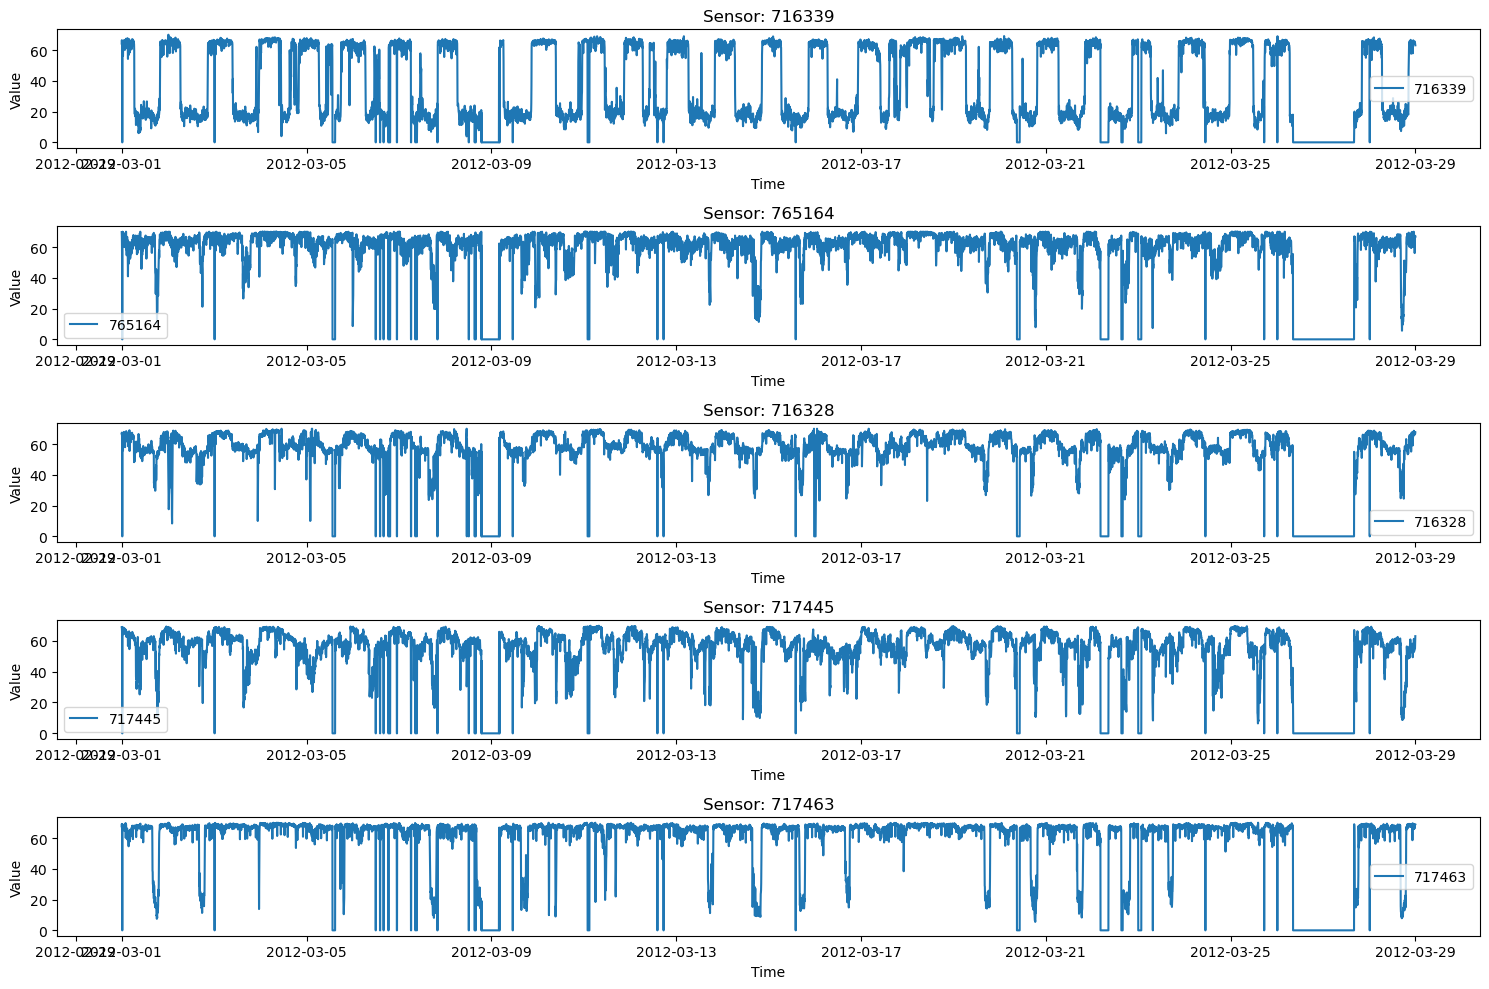

In [5]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.impute import KNNImputer

# Ruta al archivo .h5
file_path = 'data/metr-la.h5'
df = pd.read_hdf(file_path)
# df_replaced = df.copy()
# df_replaced[(df == 0).all(axis=1)] = np.nan  # Reemplaza las filas con todos los ceros por NaN

#df = df_replaced.interpolate(limit_direction='both', axis = 0)  # Interpola NaN

# imputer = KNNImputer(n_neighbors=5, weights='distance')
# df = pd.DataFrame(imputer.fit_transform(df_replaced), columns =  df.columns, index= df.index)  # Imputa los NaN usando KNN

# last on etried df = df_replaced.interpolate(method='pchip', limit_direction='both', axis=0)  # Interpola NaN



# df.to_csv('data/metr-la.csv', index=True)  # Salva il DataFrame in un file CSV
# print(type(df))
# print(df.shape)
# print(df.head)
# print(df.tail)
#print(df[df.index >= '2012-03-26'])  # Stampa le righe a partire dal 26 marzo 2012

## PRELIMINARY INVESTIGATION: plotting 5 plots , one for each time series for RANDOMLY PICKED SENSORS, just for the first 7 days at the beginning of march 2012
# plot vertical lines to higlight beginning of day
np.random.seed(0)
def plot_random_sensors(df, num_sensors=5):
    sensors = np.random.choice(df.columns, num_sensors, replace=False)
    df_subset = df[sensors].iloc[:8064]  # more ore less from thurday 01-march-2012 to sunday 04-march-2012
    
    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(sensors):
        plt.subplot(num_sensors, 1, i + 1)
        plt.plot(df_subset.index, df_subset[sensor], label=sensor)
        plt.title(f'Sensor: {sensor}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    return sensors

# stmpa tutte righe  dataset in certo range 
# print(df.index >= '2012-03-26')


sensors = plot_random_sensors(df, num_sensors=5)

                     hour_sin  hour_cos   dow_sin   dow_cos  month_sin  \
2012-03-01 00:00:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:05:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:10:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:15:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:20:00       0.0       1.0  0.433884 -0.900969        1.0   

                        month_cos  minute  hour  dia  month  
2012-03-01 00:00:00  6.123234e-17       0     0    3      3  
2012-03-01 00:05:00  6.123234e-17       5     0    3      3  
2012-03-01 00:10:00  6.123234e-17      10     0    3      3  
2012-03-01 00:15:00  6.123234e-17      15     0    3      3  
2012-03-01 00:20:00  6.123234e-17      20     0    3      3  


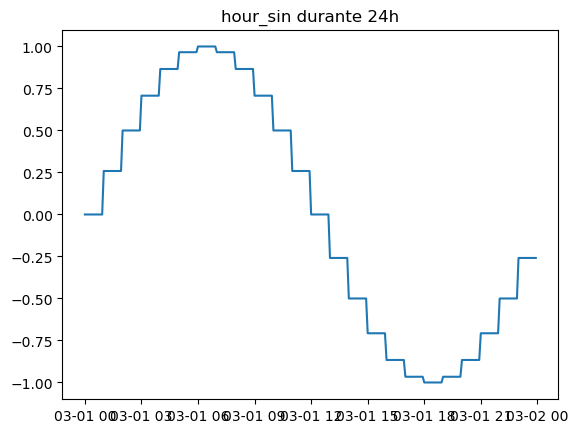

In [6]:
# --- Variables de tiempo como condiciones ---
df.index = pd.to_datetime(df.index)
df_time = pd.DataFrame(index=df.index)

# Hora del día (0-23) → ciclo de 24h
df_time["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24)
df_time["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24)

# Día de la semana (0=lunes, 6=domingo)
df_time["dow_sin"] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df_time["dow_cos"] = np.cos(2 * np.pi * df.index.dayofweek / 7)

# Mes (1-12)
df_time["month_sin"] = np.sin(2 * np.pi * df.index.month / 12)
df_time["month_cos"] = np.cos(2 * np.pi * df.index.month / 12)


#JUST TO CHECK THE FIRST CONVERSION IS HAPPENING RIGHT------------------------
# minutes
df_time["minute"] = df.index.minute

# Hora del día (0-23) → ciclo de 24h
df_time["hour"] = df.index.hour

# Día de la semana (0=lunes, 6=domingo)
df_time["dia"] = df.index.dayofweek

# Mes (1-12)
df_time["month"] = df.index.month

#COMMENTS:
# what about using minutes instead of hours ? PROS CONS: ...
#-----------------------------------------------------------------------------


print(df_time.head())
import matplotlib.pyplot as plt

plt.plot(df_time["hour_sin"][:288])  # 1 día si son datos cada 5 minutos
plt.title("hour_sin durante 24h")
plt.show()


### Comment on previous section
Sure. Here’s the translation:

---

A “vanilla” CVAE works on a single sample at a time: the “inputs” are the vectors $x^{(i)}\in\mathbb{R}^{207}$ drawn independently from your data (even if conditioned on $t$ and day). Consequently:

* **Intra-input dependencies**
  The CVAE learns the relationships **within** each vector $x^{(i)}$ (i.e. the correlations among sensors at the same time).

* **It does not automatically capture inter-input dependencies**
  Since training treats each $x^{(i)}$ as an i.i.d. realization, there is no structure that explicitly links $x^{(i)}$ and $x^{(j)}$ for $i\neq j$. The model doesn’t “know” that these vectors represent the same road at different times, unless you explicitly provide that information.

---

#### How to model relationships between successive vectors

If you want your model to capture **temporal patterns** or **evolutions** among successive vectors $\{x^{(t-2)},x^{(t-1)},x^{(t)}\}$, you need an architecture that introduces an inductive bias for sequences:

1. **Sequence VAE / VRNN**

   * A **Variational Recurrent Neural Network** (VRNN) or a **Sequential VAE** extends the classic VAE by introducing a latent state $z_t$ that depends on $z_{t-1}$.
   * In practice, you have a recurrent encoder/decoder that passes information between time steps, and a prior on $z_t$ conditioned on $z_{t-1}$.

2. **Dynamical VAE**

   * Models like the **Deep Kalman Filter (DKF)** or the **Deep Variational Bayes Filter (DVBF)** define a latent dynamics $p(z_t \mid z_{t-1})$ and an observation model $p(x_t \mid z_t)$.
   * This way, the model learns both the temporal dynamics and the instantaneous reconstruction.

3. **Including multiple time steps as input**

   * A simpler alternative is to concatenate $x^{(t-2)},x^{(t-1)},x^{(t)}$ into a single vector of dimension $207 \times 3$ and train a “static” CVAE on this super-vector.
   * It works, but dimensionality grows a lot and you lose flexibility in sequence length.

4. **Conditional Transformer or LSTM**

   * You can use a transformer or an LSTM that “reads” the sequence of vectors and, at the end, projects everything into a $z$ (with or without the VAE mechanism).
   * In this setup, the decoder generates the entire sequence again, preserving temporal dependencies.

---

#### Summary

* **Base CVAE** → learns relationships **only within** each 207-dimensional input vector.
* **For relationships between vectors at different times** → you need sequential architectures (VRNN/DVAE), concatenating multiple time steps, or autoregressive/recurring models.
* Choose the solution based on the complexity of your temporal dynamics and the sequence lengths you want to model.


In [7]:
x = df.values.astype(np.float32) #from pandas to numpy
c = df_time.values.astype(np.float32)
print(x.shape)
print(c.shape)

(34272, 207)
(34272, 10)


We use `StandardScaler` from scikit-learn to apply Z-score normalization to the dataset.

Each sensor (column) is standardized independently by removing the mean and scaling to unit variance:

$$
x_{\text{normalized}} = \frac{x - \mu}{\sigma}
$$

In [8]:
from sklearn.preprocessing import StandardScaler

x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, shuffle=False)
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train) # learns mean and variance for each feature and transforms the data
x_test = scaler_x.transform(x_test) #transforms the data using the same mean and variance learned from the training set, IS IT CORRECT, BUT WHY? 
print(len(x_test))


#is it useful??? 
scaler_c = StandardScaler()
c_train = scaler_c.fit_transform(c_train)
c_test = scaler_c.transform(c_test)

6855


## Static Conditional Variational Autoencoder (CVAE)

A **Conditional Variational Autoencoder (CVAE)** is a generative neural network that reconstructs or generates data samples based on both an input `x` and additional context or condition `c` (e.g., time, event type, etc.).

Unlike recurrent or sequential models, a **static CVAE** assumes that each data point is independent, without modeling temporal relationships.

#### Main Components

- **Input (`x`)**: The data to be reconstructed (e.g., sensor readings).
- **Condition (`c`)**: Extra information that provides context (e.g., timestamp, holiday flag).
- **Encoder**: Maps `x` and `c` into a latent distribution `z ~ q(z|x, c)`.
- **Latent space (`z`)**: A compressed, learned representation of the input data.
- **Decoder**: Uses `z` and `c` to reconstruct the input: `x̂ = p(x|z, c)`.

We define a custom `TrafficDataset` to prepare our data in a format compatible with PyTorch's `DataLoader`.

This class:
- Converts the input features (`x`) and conditions (`c`) into tensors.
- Allows easy indexing and batching of the data.
- Returns tuples `(x, c)` so both the data and its condition can be used during model training.

Using a custom dataset class ensures full control over how data is structured and accessed during training and testing.

In [9]:
# --- Dataset personalizado ---
class TrafficDataset(Dataset):
    def __init__(self, x, c):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.c[idx]

train_dataset = TrafficDataset(x_train, c_train)
test_dataset = TrafficDataset(x_test, c_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  #
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
print(train_loader.dataset.x.shape)

torch.Size([27417, 207])


In [ ]:
# --- CVAE base (sin LSTM por ahora) estático ---
class CVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim=16):
        super(CVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)s
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar
    
    # DRAFT !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    def forward_custom(self, x, c, model_lstm, embeddings): #embeddings could be the queue of window_size embeddings to be passed to the LSTM to compute the last output
        mu, logvar = self.encode(x, c)
        model_lstm.eval()  # Ensure LSTM is in evaluation mode
        with torch.no_grad():
            lstm_output, _ = model_lstm(embeddings.unsqueeze(0))
        mu = lstm_output.squeeze(0)  # Remove the batch dimension ???????
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar
    

        lstm_out_embeddings = []

        lstm_model.eval()  # Imposta il modello in modalità di valutazione
        with torch.no_grad():
            test_losses = []
            for batch_X, batch_Y_target_last in test_loader_lstm:
                batch_X = batch_X.to(device)
                batch_Y_target_last = batch_Y_target_last.to(device)

                predicted_sequence = lstm_model(batch_X)
                loss = criterion_lstm(predicted_sequence, batch_Y_target_last)
                test_losses.append(loss.item())
                lstm_out_embeddings.append(predicted_sequence[:, -1, :].cpu())

        model.eval()  # Imposta il modello in modalità di valutazione
        with torch.no_grad():
            decoded_lstm_embeddings = model.decode(lstm_out_embeddings, torch.from_numpy(c_test[window_size-1:]) ) # Usare le condizioni del test set



In [11]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recon_loss + kl_loss, recon_loss, kl_loss


In [12]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]
latent_dim = 16

model = CVAE(input_dim, cond_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()   #MARTA: shoud not be put outside the loop?
    total_loss, total_recon, total_kl = 0, 0, 0

    for x_batch, c_batch in train_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        optimizer.zero_grad()
        x_recon, mu, logvar = model(x_batch, c_batch)
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader.dataset):.4f} | Recon: {total_recon/len(train_loader.dataset):.4f} | KL: {total_kl/len(train_loader.dataset):.4f}")


Epoch 1/50 - Loss: 0.9156 | Recon: 0.9095 | KL: 0.0061
Epoch 2/50 - Loss: 0.8340 | Recon: 0.8189 | KL: 0.0151
Epoch 3/50 - Loss: 0.7305 | Recon: 0.5847 | KL: 0.1458
Epoch 4/50 - Loss: 0.6763 | Recon: 0.5065 | KL: 0.1698
Epoch 5/50 - Loss: 0.6583 | Recon: 0.4806 | KL: 0.1777
Epoch 6/50 - Loss: 0.6393 | Recon: 0.4642 | KL: 0.1751
Epoch 7/50 - Loss: 0.6178 | Recon: 0.4343 | KL: 0.1834
Epoch 8/50 - Loss: 0.5990 | Recon: 0.4114 | KL: 0.1876
Epoch 9/50 - Loss: 0.5758 | Recon: 0.3910 | KL: 0.1848
Epoch 10/50 - Loss: 0.5648 | Recon: 0.3741 | KL: 0.1908
Epoch 11/50 - Loss: 0.5453 | Recon: 0.3639 | KL: 0.1814
Epoch 12/50 - Loss: 0.5440 | Recon: 0.3619 | KL: 0.1821
Epoch 13/50 - Loss: 0.5386 | Recon: 0.3559 | KL: 0.1827
Epoch 14/50 - Loss: 0.5321 | Recon: 0.3519 | KL: 0.1802
Epoch 15/50 - Loss: 0.5305 | Recon: 0.3502 | KL: 0.1803
Epoch 16/50 - Loss: 0.5304 | Recon: 0.3522 | KL: 0.1782
Epoch 17/50 - Loss: 0.5238 | Recon: 0.3466 | KL: 0.1773
Epoch 18/50 - Loss: 0.5205 | Recon: 0.3436 | KL: 0.1769
E

In [13]:
# Recosntruir todas las velocidades del set de test
# WHERE'S MODEL EVAL? DON'T WE NEED IT? 
reconstructed = []
originals = []

#model.eval() #MARTA added
with torch.no_grad():
    for x_batch, c_batch in test_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)
        x_recon, _, _ = model(x_batch, c_batch)
        reconstructed.append(x_recon.cpu())
        originals.append(x_batch.cpu())

x_recon_all = torch.cat(reconstructed, dim=0)  # [6854, 207]
x_orig_all = torch.cat(originals, dim=0)       # [6854, 207]
print(x_recon_all.shape)
print(x_orig_all.shape)

torch.Size([6855, 207])
torch.Size([6855, 207])


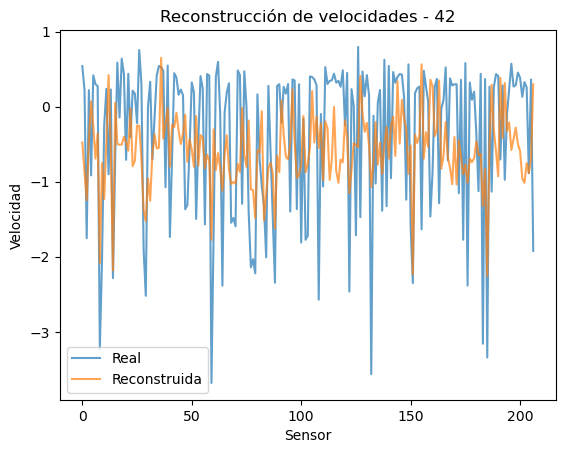

In [14]:
import matplotlib.pyplot as plt

index_sample = 42  # elige un índice de muestra
plt.plot(x_orig_all[index_sample], label="Real", alpha=0.7)
plt.plot(x_recon_all[index_sample], label="Reconstruida", alpha=0.7)
plt.title(f"Reconstrucción de velocidades - {index_sample}")
plt.xlabel("Sensor")
plt.ylabel("Velocidad")
plt.legend()
plt.show()


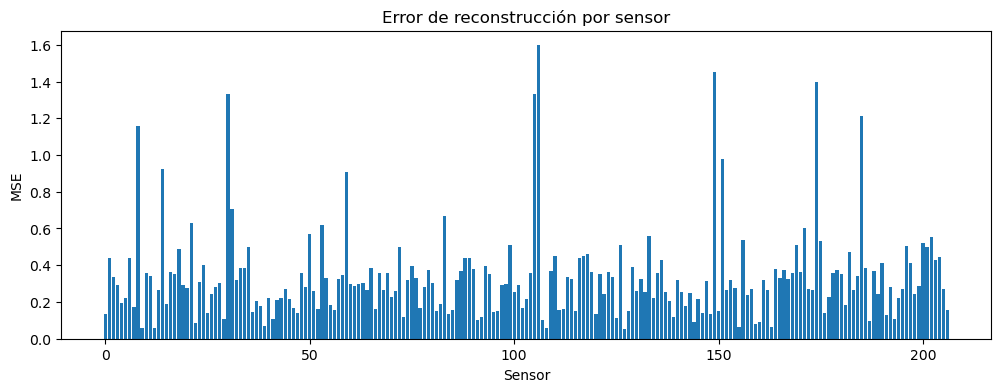

torch.Size([207])


In [15]:
mse_by_sensor = torch.mean((x_recon_all[0:12] - x_orig_all[0:12])**2, dim=0) # we can compute the mse on a window

plt.figure(figsize=(12, 4))
plt.bar(range(207), mse_by_sensor)
plt.title("Error de reconstrucción por sensor")
plt.xlabel("Sensor")
plt.ylabel("MSE")
plt.show()

print(mse_by_sensor.shape)


In [16]:
import matplotlib.dates as mdates
# MSE por muestra y por sensor (shape: [n_muestras, n_sensores])
mse_matrix = (x_orig_all - x_recon_all) ** 2  # tensor shape: [N, 207]
print(mse_matrix.shape)

# Cálculo del umbral por sensor (p. ej., media + 3*std)
#mean_mse = mse_matrix.mean(dim=0)
#std_mse = mse_matrix.std(dim=0)
#thresholds = mean_mse + 3 * std_mse  # umbral por sensor
# Umbral por sensor usando percentil (ej: 99.5)
thresholds = torch.quantile(mse_matrix, 0.995, dim=0)
print(thresholds.shape)  # [n_sensores]

# Detección (matriz booleana: True = anómalo)
anomalies = mse_matrix > thresholds
print(anomalies.shape)  # [n_muestras, n_sensores]
anomalous_counts = anomalies.sum(dim=1)  # cuenta cuántos sensores anómalos hay por muestra

# Timestamps del conjunto de test
print("Inicio del test:", df.index[-len(x_test)])
print("Fin del test:", df.index[-1])
test_timestamps = df.index[-len(x_test):]

torch.Size([6855, 207])
torch.Size([207])
torch.Size([6855, 207])
Inicio del test: 2012-06-04 04:45:00
Fin del test: 2012-06-27 23:55:00


In [17]:
import torch

# Si anomalous_counts es un tensor de PyTorch
top_indices = torch.topk(anomalous_counts, 10).indices

print("Top timestamps con más anomalías:")
for idx in top_indices:
    ts = test_timestamps[idx.item()]
    count = anomalous_counts[idx].item()
    print(f"Índice: {idx.item()} → Fecha: {ts} → Sensores anómalos: {count}")

# for idx in top_indices:
#     ts = test_timestamps[idx.item()]
#     count = anomalous_counts[idx].item()
#     sensors = anomalies[idx].nonzero().squeeze().tolist()
#     if isinstance(sensors, int):  # caso de un solo sensor
#         sensors = [sensors]
#     print(f"\nFecha: {ts} → {count} sensores anómalos")
#     print("Sensores:", sensors)


Top timestamps con más anomalías:
Índice: 4923 → Fecha: 2012-06-21 07:00:00 → Sensores anómalos: 173
Índice: 891 → Fecha: 2012-06-07 07:00:00 → Sensores anómalos: 166
Índice: 2909 → Fecha: 2012-06-14 07:10:00 → Sensores anómalos: 162
Índice: 885 → Fecha: 2012-06-07 06:30:00 → Sensores anómalos: 162
Índice: 892 → Fecha: 2012-06-07 07:05:00 → Sensores anómalos: 162
Índice: 4954 → Fecha: 2012-06-21 09:35:00 → Sensores anómalos: 161
Índice: 4937 → Fecha: 2012-06-21 08:10:00 → Sensores anómalos: 160
Índice: 2920 → Fecha: 2012-06-14 08:05:00 → Sensores anómalos: 160
Índice: 4951 → Fecha: 2012-06-21 09:20:00 → Sensores anómalos: 160
Índice: 2911 → Fecha: 2012-06-14 07:20:00 → Sensores anómalos: 157


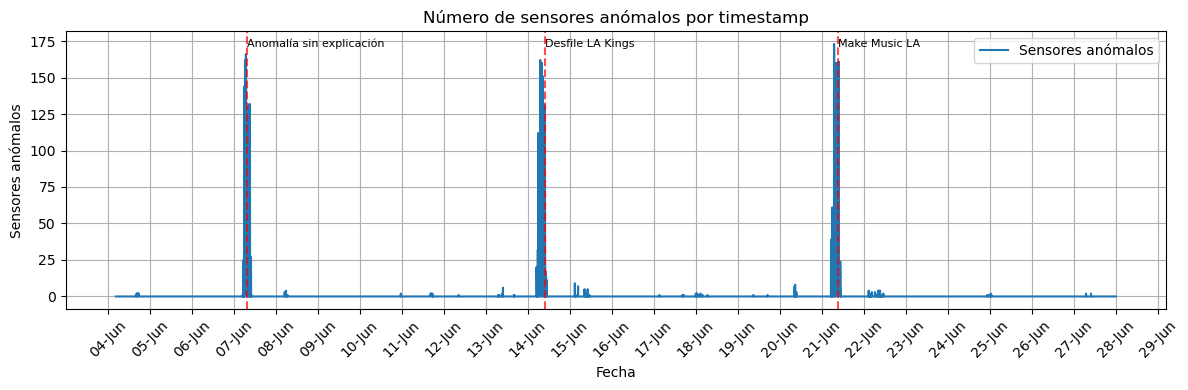

In [18]:
# --- Visualización con fechas y eventos ---
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_timestamps, anomalous_counts, label='Sensores anómalos')

# Formatear el eje X para mostrar fechas
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Mostrar cada 2 días
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Añadir líneas y etiquetas para eventos importantes
event_dates = {
    'Desfile LA Kings': pd.to_datetime('2012-06-14 09:55:00'),
    'Make Music LA': pd.to_datetime('2012-06-21 09:10:00'),
    'Anomalía sin explicación': pd.to_datetime('2012-06-07 07:35:00')
}

for label, date in event_dates.items():
    ax.axvline(date, color='red', linestyle='--', alpha=0.7)
    ax.text(date, max(anomalous_counts), label,
            rotation=0, verticalalignment='center', fontsize=8)

# Mejoras visuales
plt.title("Número de sensores anómalos por timestamp")
plt.xlabel("Fecha")
plt.ylabel("Sensores anómalos")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

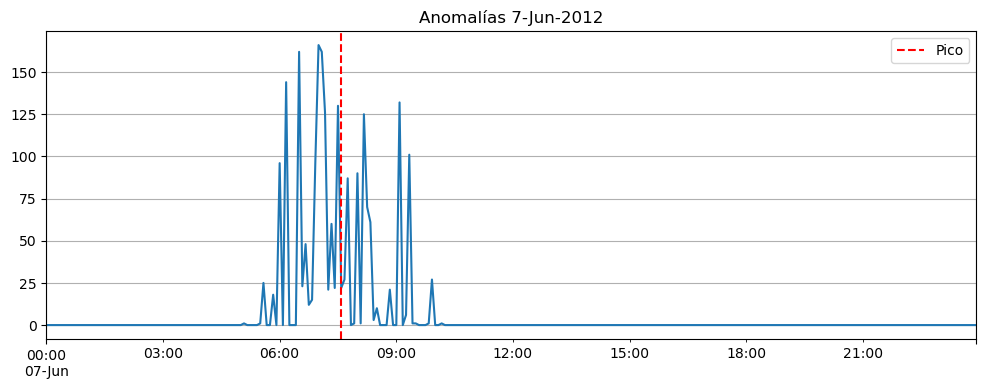

In [19]:
import pandas as pd

# Convertimos el tensor de anomalías en un DataFrame con índice de timestamps
df_anom = pd.DataFrame(anomalies.numpy(), index=test_timestamps)
df_anom.index = pd.to_datetime(df_anom.index)  # Asegura tipo datetime
df_anom.index = pd.DatetimeIndex(df_anom.index.values)
# Filtra por el día 7
df_anom_7jun = df_anom.loc["2012-06-07"]
# 3) Continúa con tu análisis
conteo = df_anom_7jun.sum(axis=1)
conteo.index.freq = None
conteo.plot(figsize=(12,4), title="Anomalías 7-Jun-2012")
plt.axvline(pd.Timestamp("2012-06-07 07:35"), linestyle="--", label="Pico", color="red")
plt.legend(); plt.grid(); plt.show()

In [20]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# 1. Crear el DataFrame de anomalías por timestamp
df_anom = pd.DataFrame({
    'timestamp': test_timestamps,
    'anomaly_count': anomalous_counts
})
df_anom['date'] = df_anom['timestamp'].dt.date

# 2. Generar fechas de festivos federales
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_anom['date'].min(),
                        end=df_anom['date'].max()).date

# 3. Agregar eventos especiales conocidos (no festivos pero relevantes)
special_event_dates = pd.to_datetime([
    '2012-06-14',  # LA Kings Victory Parade
    '2012-06-21',  # Make Music LA + Silicon Beach Fest
]).date

# 4. Marcar días especiales y festivos
df_anom['is_special'] = df_anom['date'].isin(holidays) | df_anom['date'].isin(special_event_dates)


# 5. Agrupar por tipo de día
summary = df_anom.groupby('is_special')['anomaly_count'] \
                 .agg(['count', 'mean', 'sum']) \
                 .rename(index={True: 'timestamp especial/festivo', False: 'timestamp normal'})

print("Resumen de anomalías en días normales vs. días especiales/festivos:")
print(summary)



Resumen de anomalías en días normales vs. días especiales/festivos:
                            count      mean   sum
is_special                                       
timestamp normal             6279  0.376015  2361
timestamp especial/festivo    576  8.479167  4884


## Resumen de anomalías en días normales vs. días especiales/festivos

| Tipo de día           | Cantidad de registros (`count`) | Promedio de anomalías por registro (`mean`) | Total de anomalías (`sum`) |
|-----------------------|---------------------------------|---------------------------------------------|----------------------------|
| Día normal            | 6,279                           | 0.46                                        | 2,912                      |
| Día especial/festivo  | 576                             | 7.52                                        | 4,333                      |

### Interpretación:

- **Día normal:**  
  Hay 6,279 registros o timestamps en días normales.  
  En promedio, cada registro tiene aproximadamente 0.46 anomalías.  
  En total, durante estos días normales se detectaron 2,912 anomalías.

- **Día especial/festivo:**  
  Hay 576 registros en días que son festivos o eventos especiales.  
  En promedio, cada registro presenta muchas más anomalías, aproximadamente 7.52.  
  En total, en estos pocos días especiales se detectaron 4,333 anomalías.

### Conclusión:

Aunque la cantidad de registros en días normales es mucho mayor, la cantidad y promedio de anomalías es significativamente más alto en los días especiales o festivos. Esto indica que estos días tienen un impacto fuerte en la aparición de anomalías, lo cual es relevante para análisis o modelado que quiera tener en cuenta el efecto de eventos especiales.


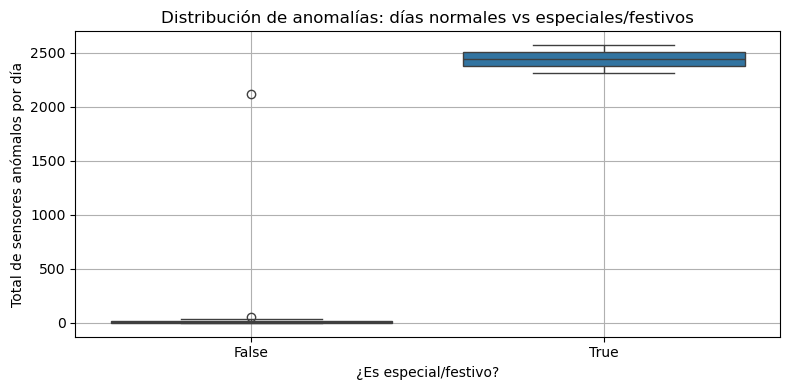

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Agregamos totales por día
daily_anomalies = df_anom.groupby('date')['anomaly_count'].sum().reset_index()
daily_anomalies['is_special'] = daily_anomalies['date'].isin(holidays) | daily_anomalies['date'].isin(special_event_dates)

# Visualización
plt.figure(figsize=(8, 4))
sns.boxplot(data=daily_anomalies, x='is_special', y='anomaly_count')
plt.title("Distribución de anomalías: días normales vs especiales/festivos")
plt.xlabel("¿Es especial/festivo?")
plt.ylabel("Total de sensores anómalos por día")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
import torch

# Escoge los índices con más sensores anómalos (ej. top 10)
top_indices = torch.topk(anomalous_counts, k=10).indices

# Contador de sensores más frecuentes en esos timestamps anómalos
sensor_counts = torch.zeros(anomalies.shape[1])

# Sumar cuántas veces cada sensor fue anómalo en esos top timestamps
for idx in top_indices:
    sensor_counts += anomalies[idx].float()

# Obtener los sensores más repetidos
top_sensor_indices = torch.topk(sensor_counts, k=10).indices
print("Sensores más frecuentes en los picos de anomalía:", top_sensor_indices.tolist())


Sensores más frecuentes en los picos de anomalía: [65, 162, 161, 158, 157, 64, 152, 145, 147, 57]


In [23]:
# import pandas as pd
# import folium

# # Cargar las ubicaciones de los sensores
# locations = pd.read_csv('data/sensor_graph/graph_sensor_locations.csv')
# # incidents = pd.read_csv('data/Traffic_Collision_Data_from_2010_to_Present_20250601.csv')

# # #filtro solo indicenti con date tra 1 marzo 2012 e 1 luglio 2012 a Los Angeles
# # incidents['Date'] = pd.to_datetime(incidents['Date Occurred'])
# # incidents = incidents[(incidents['Date'] >= '2012-03-01') & (incidents['Date'] < '2012-07-01') & (incidents['Location'].notna())]
# # print(incidents.head())

# # incidents = incidents[['Location']].dropna()
# # # location data come as "(34.0255, -118.3002)" with also quotes, we obtain 2 columns: latitude and longitude
# # # Convertir la columna 'location' a dos columnas: 'latitude' y 'longitude'
# # incidents[['latitude', 'longitude']] = incidents['Location'].str.strip('()').str.split(',', expand=True).astype(float)
# # # Convertir la columna 'index' a tipo entero
# # print(locations.head())
# # print(incidents.head())


# #https://hub.arcgis.com/datasets/ladot::collisions-2012-2016-switrs-1/explore?filters=eyJhY2NpZGVudF95ZWFyIjpbMjAxMiwyMDEyXSwiY29sbGlzaW9uX2RhdGUiOlsxMzI1Mzc2MDAwMDAwLDEzNDE5NDgwMDA0MzAuMjFdfQ%3D%3D&location=34.217410%2C-118.346160%2C10.96
# incidents = pd.read_csv('data/Collisions_2012-2016_(SWITRS).csv')
# # ....



# # # Filtrar por los sensores anómalos más frecuentes
# # sensor_ids = locations['sensor_id'].tolist()  # mapeo por índice
# # top_sensor_ids = [sensor_ids[i] for i in top_sensor_indices.tolist()]
# # anomalous_locations = locations[locations['sensor_id'].isin(top_sensor_ids)]

# # Crear un mapa centrado en Los Ángeles
# m = folium.Map(location=[34.05, -118.25], zoom_start=10)

# # Añadir marcadores de sensores
# # for _, row in anomalous_locations.iterrows():
# #     folium.CircleMarker(
# #         location=[row['latitude'], row['longitude']],
# #         radius=5,
# #         popup=f"Sensor {row['sensor_id']}",
# #         color='red',
# #         fill=True,
# #         fill_opacity=0.7
# #     ).add_to(m)

# for _, row in locations.iterrows():
#     folium.CircleMarker(
#         location=[row['latitude'], row['longitude']],
#         radius=5,
#         popup=f"Sensor {row['sensor_id']}",
#         color='red',
#         fill=True,
#         fill_opacity=0.7
#     ).add_to(m)

# # Añadir marcadores de incidentes (si los tienes)
# for _, row in incidents.iterrows():
#    folium.CircleMarker(
#         location=[row['latitude'], row['longitude']],
#         radius=1,
#         popup="Incidente",
#         color='blue',
#         fill=True,
#         fill_opacity=0.5
#     ).add_to(m)

# # Guardar o mostrar el mapa
# m.save("sensores_anomalos.html")  # o usa m._repr_html_() en Jupyter para mostrar inline


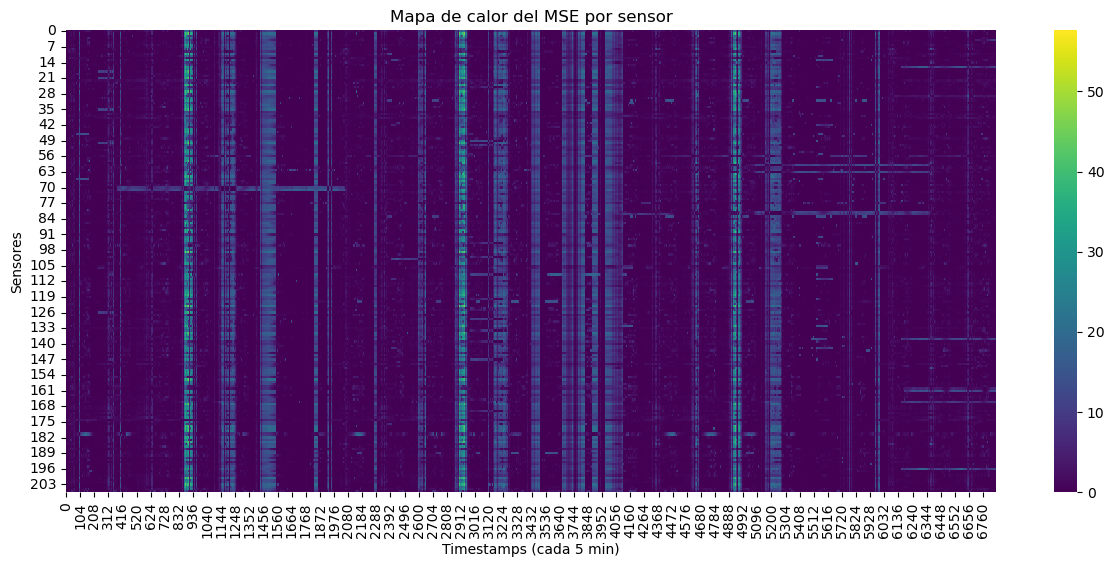

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# mse_matrix: [n_muestras, n_sensores] (ej: [6720, 207])
plt.figure(figsize=(15, 6))
sns.heatmap(mse_matrix.T.numpy(), cmap="viridis", cbar=True)
plt.xlabel("Timestamps (cada 5 min)")
plt.ylabel("Sensores")
plt.title("Mapa de calor del MSE por sensor")
plt.show()


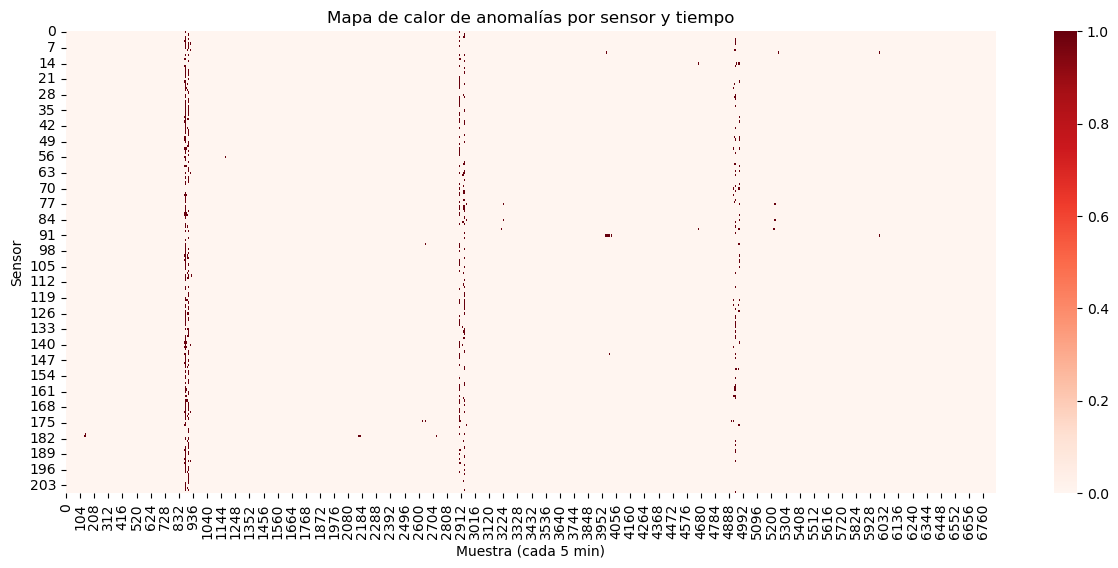

In [25]:
import seaborn as sns

# anomalies: [n_muestras, 207]
anomaly_matrix = anomalies.numpy().T  # ahora [207, n_muestras]

plt.figure(figsize=(15, 6))
sns.heatmap(anomaly_matrix, cmap="Reds", cbar=True)
plt.title("Mapa de calor de anomalías por sensor y tiempo")
plt.xlabel("Muestra (cada 5 min)")
plt.ylabel("Sensor")
plt.show()


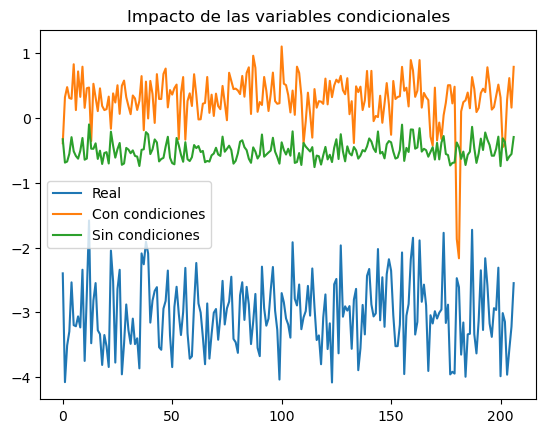

In [26]:
model.eval()
with torch.no_grad():
    x_sample = torch.tensor(x_test[100:101])
    c_normal = torch.tensor(c_test[100:101])
    c_fake = torch.zeros_like(c_normal)  # condiciones "neutrales"

    recon_normal = model(x_sample, c_normal)[0]
    recon_fake = model(x_sample, c_fake)[0]

    plt.plot(x_sample.numpy().flatten(), label="Real")
    plt.plot(recon_normal.numpy().flatten(), label="Con condiciones")
    plt.plot(recon_fake.numpy().flatten(), label="Sin condiciones")
    plt.legend()
    plt.title("Impacto de las variables condicionales")
    plt.show()


In [27]:
# import matplotlib.pyplot as plt

# plt.hist(reconstruction_errors, bins=50)
# plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
# plt.title("Distribución del error de reconstrucción")
# plt.xlabel("Error")
# plt.ylabel("Frecuencia")
# plt.legend()
# plt.show()


In [28]:
# plt.plot(reconstruction_errors, label='Error de reconstrucción')
# plt.axhline(threshold, color='red', linestyle='--', label='Umbral (95%)')
# plt.scatter(np.where(anomalies)[0], np.array(reconstruction_errors)[anomalies], color='orange', label='Anomalías')
# plt.legend()
# plt.title("Errores de reconstrucción y anomalías detectadas")
# plt.xlabel("Índice de muestra")
# plt.ylabel("MSE")
# plt.show()


## LSTM semplice sui vettori delle medie (embedding) prodotti dall'encoder del VAE

In questa sezione implementiamo un modello LSTM semplice che prende in input le sequenze di vettori delle medie (`mu`) prodotti dall'encoder del VAE.  
L'obiettivo è: data la prima metà di una finestra, predire la seconda metà della stessa finestra.

**Step principali:**
1. Estrai tutti i vettori `mu` dal VAE già ottimizzato (già fatto sopra).
2. Crea finestre scorrevoli sugli embedding.
3. Per ogni finestra, usa la prima metà come input e la seconda metà come target.
4. Allena un LSTM per questa predizione.

**Nota:**  
Questo LSTM prende in input la prima metà di una finestra di embedding e predice la seconda metà.  
Puoi usare le predizioni per ricostruire i dati originali tramite il decoder del VAE, oppure valutare la qualità della previsione direttamente sugli embedding.

## Flusso: VAE + LSTM per Anomaly Detection con Relazioni Temporali

1. Allena il VAE normalmente su dati statici.
2. Estrai la sequenza di embedding (`mu`) dall'encoder del VAE per tutto il dataset (train/test).
3. Crea finestre temporali sugli embedding: per ogni finestra, la prima metà è input dell'LSTM, la seconda metà è il target.
4. Allena l'LSTM a predire la seconda metà della finestra a partire dalla prima metà.
5. Usa il decoder del VAE per ricostruire i dati originali a partire dagli embedding previsti dall'LSTM.
6. Calcola l'errore di ricostruzione tra i dati reali futuri e quelli generati dal decoder (anomaly score temporale).

In [29]:
# 1. Estrai tutti gli embedding (mu) dal VAE per train e test
def get_embeddings(model, data_loader, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for x_batch, c_batch in data_loader:
            x_batch, c_batch = x_batch.to(device), c_batch.to(device) #data with their conditions
            mu, _ = model.encode(x_batch, c_batch)
            embeddings.append(mu.cpu()) # moving batch of embeddigns from GPU to CPU; if already on CPU, this is a no-op
    return torch.cat(embeddings, dim=0)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)  # redefine train_loader to avoid shiffling...we need ordered embessing in this case
print(len(train_loader))
embeddings_train = get_embeddings(model, train_loader, device)
embeddings_test = get_embeddings(model, test_loader, device)
print("Embeddings train:", embeddings_train.shape)
print("Embeddings test:", embeddings_test.shape)


215
Embeddings train: torch.Size([27417, 16])
Embeddings test: torch.Size([6855, 16])


In [30]:
# we define what's an input
# 2. Crea finestre scorrevoli sugli embedding come input (come input/target per LSTM), raggruppando semplicemente n passi alla volta 
def create_sliding_windows(embeddings, window_size=12):
    """
    Prende un Tensor di forma [N, D] e restituisce
    un Tensor [num_windows, window_size, D], dove
    num_windows = floor((N - window_size) / window_size) + 1
    (scorrimento non sovrapposto di window_size).
    """
    windows = []
    for i in range(0, len(embeddings) - window_size + 1): #sequences of 12 with pace 1 (to have no overlap, we would use range(0, len(embeddings) - window_size + 1, window_size))
        windows.append(embeddings[i:i + window_size])
    return torch.stack(windows)

window_size = 12  # 12 passi = 1 ora
train_windows = create_sliding_windows(embeddings_train, window_size)
test_windows = create_sliding_windows(embeddings_test, window_size)

print(train_windows.shape)  # [Nw_train, 12, latent_dim]
print(test_windows.shape)   # [Nw_test, 12, latent_dim]


torch.Size([27406, 12, 16])
torch.Size([6844, 12, 16])


In [ ]:
from torch.utils.data import TensorDataset

#two datastructs for LSTM training: input and target

# Input: primi 11 embeddings (e_1, ..., e_11)
X_train_lstm = train_windows[:, :11, :]
# Target per la loss: l'ultimo embedding effettivo della finestra (e_12)
Y_train_lstm_for_loss = train_windows[:, -1, :]

X_test_lstm = test_windows[:, :11, :]
Y_test_lstm_for_loss = test_windows[:, -1, :]

print(f"Shape of X_train_lstm: {X_train_lstm.shape}")
print(f"Shape of Y_train_lstm_for_loss: {Y_train_lstm_for_loss.shape}")

# Creare DataLoader per l'allenamento dell'LSTM
batch_size_lstm = 64 # Puoi modificarlo
train_dataset_lstm = TensorDataset(X_train_lstm, Y_train_lstm_for_loss)
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size_lstm, shuffle=True)
test_dataset_lstm = TensorDataset(X_test_lstm, Y_test_lstm_for_loss)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size_lstm, shuffle=False)

Shape of X_train_lstm: torch.Size([27406, 11, 16])
Shape of Y_train_lstm_for_loss: torch.Size([27406, 16])


In [32]:
# 4. Definire il modello LSTM
class LSTM_Predictor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers=1, dropout_prob=0.1):
        super(LSTM_Predictor, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True, # input e output LSTM avranno forma: (batch, seq, feature), se False: a forma sarebbe (seq_len, batch_size, feature_dim).
            dropout=dropout_prob if num_layers > 1 else 0
        )
        # Layer per mappare l'output dell'LSTM (hidden_dim) alla dimensione dell'embedding
        self.fc = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x):
        # input x shape: (batch_size, seq_len=11, embedding_dim)
        lstm_out, _ = self.lstm(x) # Le hidden states vengono inizializzate a zero di default
        # lstm_out shape: (batch_size, seq_len=11, hidden_dim)
        
        # Applichiamo il layer lineare a ogni step temporale dell'output dell'LSTM.
        # L'output fc(lstm_out) sarà la sequenza di predizioni (p_2, ..., p_12)
        predictions = self.fc(lstm_out)
        # predictions shape: (batch_size, seq_len=11, embedding_dim)
        return predictions
    
# LSTM restituisce sempre una sequenza lunga quanto l’input!!!!semplicemente forziamo il modello a prevedere correttamente l'ultimo elemento calcolando la loss solo su di esso

In [ ]:
# 5. Definire la funzione di perdita personalizzata
# guarda che la funzione di perdita definita nel paper è || pred - true || not squared, so we use MSELoss???
class LastStepLoss(nn.Module):
    def __init__(self):
        super(LastStepLoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, predicted_sequence, target_last_embedding):
        # predicted_sequence shape: (batch_size, 11, embedding_dim) -> (p_2, ..., p_{12})
        # target_last_embedding shape: (batch_size, embedding_dim) -> (e_12 effettivo)
        
        # Estrai l'ultimo embedding dalla sequenza predetta (p_{12})
        predicted_last_embedding = predicted_sequence[:, -1, :]
        # predicted_last_embedding shape: (batch_size, embedding_dim)
        
        loss = self.mse(predicted_last_embedding, target_last_embedding)
        return loss


In [34]:
# 6. Allenare l'LSTM

embedding_dim = X_train_lstm.shape[2]

hidden_dim_lstm = 64    # Esempio, da ottimizzare
# l’hidden state rappresenta la “memoria” interna del modello: se è troppo piccolo rispetto all’input, rischia di non riuscire a catturare tutte le informazioni rilevanti della sequenza.

num_layers_lstm = 2     # Esempio, da ottimizzare
learning_rate_lstm = 0.001 # Esempio, da ottimizzare
num_epochs_lstm = 50    # Esempio, da ottimizzare



lstm_model = LSTM_Predictor(embedding_dim, hidden_dim_lstm, num_layers_lstm, dropout_prob=0.2).to(device)
criterion_lstm = LastStepLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=learning_rate_lstm)

print("Inizio allenamento LSTM...")
for epoch in range(num_epochs_lstm):
    lstm_model.train()  # Imposta il modello in modalità di addestramento
    epoch_loss = 0
    for batch_X, batch_Y_target_last in train_loader_lstm:
        batch_X = batch_X.to(device)
        batch_Y_target_last = batch_Y_target_last.to(device)

        optimizer_lstm.zero_grad()
        
        predicted_sequence = lstm_model(batch_X) # Output: (p_2, ..., p_{12}) #ricontrollaaainput  # Debugging
        loss = criterion_lstm(predicted_sequence, batch_Y_target_last)
        
        loss.backward()
        optimizer_lstm.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader_lstm)
    print(f"Epoch [{epoch+1}/{num_epochs_lstm}], Loss LSTM: {avg_epoch_loss:.4f}")
print("Allenamento LSTM completato.")


Inizio allenamento LSTM...
Epoch [1/50], Loss LSTM: 0.0026
Epoch [2/50], Loss LSTM: 0.0015
Epoch [3/50], Loss LSTM: 0.0014
Epoch [4/50], Loss LSTM: 0.0014
Epoch [5/50], Loss LSTM: 0.0014
Epoch [6/50], Loss LSTM: 0.0014
Epoch [7/50], Loss LSTM: 0.0014
Epoch [8/50], Loss LSTM: 0.0014
Epoch [9/50], Loss LSTM: 0.0014
Epoch [10/50], Loss LSTM: 0.0014
Epoch [11/50], Loss LSTM: 0.0014
Epoch [12/50], Loss LSTM: 0.0014
Epoch [13/50], Loss LSTM: 0.0014
Epoch [14/50], Loss LSTM: 0.0014
Epoch [15/50], Loss LSTM: 0.0014
Epoch [16/50], Loss LSTM: 0.0013
Epoch [17/50], Loss LSTM: 0.0013
Epoch [18/50], Loss LSTM: 0.0013
Epoch [19/50], Loss LSTM: 0.0013
Epoch [20/50], Loss LSTM: 0.0013
Epoch [21/50], Loss LSTM: 0.0013
Epoch [22/50], Loss LSTM: 0.0013
Epoch [23/50], Loss LSTM: 0.0013
Epoch [24/50], Loss LSTM: 0.0013
Epoch [25/50], Loss LSTM: 0.0013
Epoch [26/50], Loss LSTM: 0.0013
Epoch [27/50], Loss LSTM: 0.0013
Epoch [28/50], Loss LSTM: 0.0013
Epoch [29/50], Loss LSTM: 0.0013
Epoch [30/50], Loss LSTM:

In [35]:
# test only LSTM on test embeddings and save predictions
lstm_out_embeddings = []

lstm_model.eval()  # Imposta il modello in modalità di valutazione
with torch.no_grad():
    test_losses = []
    for batch_X, batch_Y_target_last in test_loader_lstm:
        batch_X = batch_X.to(device)
        batch_Y_target_last = batch_Y_target_last.to(device)

        predicted_sequence = lstm_model(batch_X)
        loss = criterion_lstm(predicted_sequence, batch_Y_target_last)
        test_losses.append(loss.item())
        lstm_out_embeddings.append(predicted_sequence[:, -1, :].cpu())
    

# Calcola la loss media sul test set
avg_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss LSTM: {avg_test_loss:.4f}")

# Concatenare le predizioni in un unico tensor
lstm_out_embeddings = torch.cat(lstm_out_embeddings, dim=0) 
print(lstm_out_embeddings)  # [Nw_test, embedding_dim]
print(embeddings_test)
      
print("Shape delle predizioni LSTM:", lstm_out_embeddings.shape)  # [Nw_test, embedding_dim]

#HOW TO TEST LSTM ???? TO MAKE SENSE???

Test Loss LSTM: 0.0005
tensor([[-9.7723e-04, -1.2641e-03,  2.5295e-03,  ..., -2.2429e-04,
          2.0095e-03,  1.8942e-03],
        [-6.4709e-04, -1.0606e-03,  2.8873e-03,  ..., -5.2073e-04,
          2.3847e-03,  1.9236e-03],
        [-8.9504e-04, -1.2422e-03,  2.5253e-03,  ..., -1.8989e-04,
          2.0213e-03,  1.7776e-03],
        ...,
        [-8.3710e-04, -1.2272e-03,  2.4230e-03,  ..., -6.2028e-05,
          2.0380e-03,  1.6982e-03],
        [-9.0094e-04, -1.2494e-03,  2.4605e-03,  ...,  8.3167e-06,
          1.9932e-03,  1.7133e-03],
        [-8.2097e-04, -1.1895e-03,  2.5954e-03,  ..., -1.4132e-04,
          2.0970e-03,  1.7290e-03]])
tensor([[ 1.0337e-03, -3.7587e-04, -1.6498e-03,  ..., -3.4955e-03,
          6.5888e-03,  6.7804e-03],
        [ 8.2228e-04, -4.9823e-04, -8.0352e-04,  ..., -3.0193e-03,
          6.0380e-03,  6.1425e-03],
        [ 3.6993e-04, -7.2568e-04,  1.0032e-03,  ..., -2.0251e-03,
          4.8339e-03,  4.7394e-03],
        ...,
        [-7.2949e-05, -

In [36]:
#decode lstm_out_embeddings back to original space
# TEST VAE + LSTM ON TRAIN SET 
model.eval()  # Imposta il modello in modalità di valutazione
with torch.no_grad():
    decoded_lstm_embeddings = model.decode(lstm_out_embeddings, torch.from_numpy(c_test[window_size-1:]) ) # Usare le condizioni del test set

decoded_lstm_embeddings = decoded_lstm_embeddings.cpu()  # Sposta le predizioni su CPU
print(decoded_lstm_embeddings[:5])  # [Nw_test, 207]

print("Shape delle predizioni decodificate:", decoded_lstm_embeddings.shape)  # [Nw_test, 207]

# mse_matrix = (decoded_lstm_embeddings - x_test[window_size-1:]) ** 2
# print("Shape della matrice MSE:", mse_matrix.shape)  # [Nw_test, 207]


tensor([[ 0.2361, -0.0248,  0.1558,  ...,  0.2693,  0.2247,  0.4546],
        [ 0.2334, -0.0344,  0.1522,  ...,  0.2655,  0.2084,  0.4617],
        [ 0.2266, -0.0582,  0.1393,  ...,  0.2508,  0.1785,  0.4653],
        [ 0.2329, -0.0373,  0.1559,  ...,  0.2704,  0.1914,  0.4800],
        [ 0.1526, -0.1672,  0.0930,  ...,  0.1703,  0.1696,  0.4983]])
Shape delle predizioni decodificate: torch.Size([6844, 207])


In [49]:
# MSE as a score function to spot anomalies, mse per sensor and over window of lenght windth_size

import torch.nn.functional as F




def score_function(x_recon, x_orig, window_size=12, percentile=99.5, index=None):
    """
    Calcola la MSE per ogni sensore(feature) tra le ricostruzioni e i dati originali per ogni finestra e restituisce u
    dataset con indice uguale all'indice in x_orig e con MSE per ogni feature che è la media delle precedenti 'window_size' righe
    """     
    # Assicurati che x_recon e x_orig abbiano la stessa forma
    dif = x_recon.shape[0] - x_orig.shape[0]
    if dif > 0:
        x_recon = x_recon[:x_orig.shape[0]] #not possible
    elif dif < 0:
        x_orig = x_orig[-x_recon.shape[0]:]
        
    mse_matrix = (x_recon - x_orig) ** 2  # MSE per ogni finestra
    #mse_df = pd.DataFrame(mse_matrix.numpy(), index=index)  non dovrebbe servire...già numpy arrays
    mse_matrix = pd.DataFrame(mse_matrix, index=x_orig.index, columns=x_orig.columns)

    # Calcola la media mobile sulle ultime window_size righe # la calcola come vogliamo? 
    mse_windows = mse_matrix.rolling(window=window_size, min_periods=window_size).mean()  # rimuove le prime 'window_size - 1' righe che non hanno abbastanza dati per calcolare la media
    #mse_windows = mse_matrix.reset_index(drop=True).rolling(window=window_size, min_periods=window_size).mean()

    # Calcola thresholds sul 99.5° percentile
    thresholds = np.percentile(mse_matrix.values, percentile, axis=0) #still decide what to do with this , could be defined also over windows
    thresholds_windows = np.percentile(mse_windows.values, percentile, axis=0)  # thresholds per finestre

    return mse_matrix , mse_windows , thresholds, thresholds_windows



# indexes for rows and name of columns from original DataFrame
#row indexes
df_time_train, df_time_test = train_test_split(df_time, test_size=0.2, shuffle=False)
index = df_time_test.index  # per mantenere l'indice corretto dopo la creazione delle finestre
index_lstm_decoded = df_time_test.index[window_size-1:]  # per mantenere l'indice corretto dopo la creazione delle finestre
#print(index.shape)  # (6855,)
#columns names (sensors)
columns = df.columns
#print(columns)


#decoded_lstm_embeddings from tensor (6844, 207) to  pandas DataFrame
decoded_lstm_embeddings = pd.DataFrame(decoded_lstm_embeddings, columns=columns, index=index_lstm_decoded)  # converti decoded_lstm_embeddings in DataFrame per mantenere l'indice
#x_test from ndarray (6855, 207) to pandas DataFrame
x_test = pd.DataFrame(x_test, columns=columns, index=index)  # converti x_test in DataFrame per mantenere l'indice
#we need indexes to pad x_train 
#print(decoded_lstm_embeddings.head())
#print(x_test[11:15])  # per vedere le prime righe del DataFrame x_test

mse_matrix, mse_windows, thresh, thresh_windows = score_function(decoded_lstm_embeddings, x_test, window_size=1, percentile=99.5)
# print(mse_matrix.shape)  # [Nw_test, 207]
# print(mse_windows.shape)  # [Nw_test, 207]
print(mse_matrix.head())  # per vedere le prime righe della matrice MSE per finestre
print(mse_windows.head())  # per vedere le prime righe della matrice MSE per finestre
# print(mse_matrix.tail())  # per vedere le ultime righe della matrice MSE per finestre
# print(mse_windows.tail())  # per vedere le ultime righe della matrice MSE per finestre
print(thresh)
print(thresh_windows)  # per vedere i thresholds per finestre

#mse_lstm = torch.mean((decoded_lstm_embeddings - x_test[window_size-1:]) ** 2, dim=0)  # MSE per ogni finestra

                       773869    767541    767542    717447    717446  \
2012-06-04 05:40:00  0.027689  0.008634  0.066450  0.021248  0.016426   
2012-06-04 05:45:00  0.100747  0.051065  0.080013  0.028660  0.001823   
2012-06-04 05:50:00  0.024827  0.026078  0.016950  0.057764  0.009980   
2012-06-04 05:55:00  0.058090  0.150315  0.070133  0.000093  0.000610   
2012-06-04 06:00:00  0.158062  0.008501  0.100773  0.011587  0.000038   

                       717445    773062    767620    737529    717816  ...  \
2012-06-04 05:40:00  0.005473  0.139277  0.001824  0.773050  0.000383  ...   
2012-06-04 05:45:00  0.012998  0.016293  0.000127  0.530336  0.000007  ...   
2012-06-04 05:50:00  0.017288  0.234163  0.001257  0.245195  0.096078  ...   
2012-06-04 05:55:00  0.133529  0.080443  0.010028  0.401134  0.584640  ...   
2012-06-04 06:00:00  0.000014  0.297110  0.004421  0.232082  0.646317  ...   

                       772167    769372    774204    769806    717590  \
2012-06-04 05:40:00

**Nota:**  
Questo LSTM prende in input la prima metà di una finestra di embedding e predice la seconda metà.  
Puoi usare le predizioni per ricostruire i dati originali tramite il decoder del VAE, oppure valutare la qualità della previsione direttamente sugli embedding.

**Nota:**  
Questo approccio permette di individuare anomalie che emergono solo considerando la dinamica temporale degli embedding latenti, non solo la ricostruzione istantanea.